In [1]:
# Импортируем все необходимые библиотеки
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
# Подключаемся к clickhouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
# Вытаскиваем пользователей
q = """
SELECT distinct user_id
FROM {db}.feed_actions
WHERE toDate(time) >= '2022-05-17' and toDate(time) <= '2022-05-23'
"""

users_df = pandahouse.read_clickhouse(q, connection=connection)
users_df.head()

,user_id
0,3011
1,11066
2,14843
3,15938
4,1725


In [4]:
# Делаем группы
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as exp_group, 
    uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-05-17' and toDate(time) <= '2022-05-23'
group by exp_group 
"""

pandahouse.read_clickhouse(q, connection=connection)

,exp_group,uniqExact(user_id)
0,0,8552
1,1,8496
2,2,8491
3,3,8559
4,4,8487


In [5]:
# Записываем группу 2 и 3 в датафрейм

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-05-17' and toDate(time) <= '2022-05-23'
    and exp_group in (2, 3)
GROUP BY exp_group, user_id
"""

df= pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [6]:
# Делаем симуляцию 10000 АА-тестов
# На каждой итерации формируем подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы
# Затем проводим сравнение этих подвыборок t-testом.

In [7]:
from numpy import random
res = []
for _ in range(10000):
  a = random.choice(df.query('exp_group==2').ctr, size=500, replace=True)
  b = random.choice(df.query('exp_group==3').ctr, size=500, replace=True)
  pval = stats.ttest_ind(a,b,equal_var=False)
  res.append(pval[1])

<AxesSubplot:ylabel='Count'>

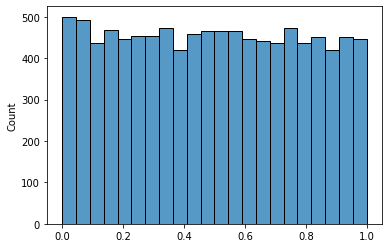

In [11]:
# Cтроим гистограмму распределения получившихся 10000 p-values

sns.histplot(res)

In [14]:
# Считаем, какой процент p values оказался меньше либо равен 0.05

df = pd.DataFrame(data=res, columns=['pvalue'])
(df.query('pvalue <= 0.05').shape[0]/df.shape[0])*100

5.57

In [15]:
# Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования

Ложноположительных результатов получилось несколько больше ожидаемых 5%, но в пределах погрешности. Поэтому на первый взгляд кажется, что система сплитования работает корректно